In [3]:
import os
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [4]:
# 1. Camera Calibration and Distortion Correction

In [5]:
# to capture the transformation between the 3D world and the 2D points
def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

In [6]:
cal_images = glob.glob('camera_cal/calibration*.jpg')
nx, ny = 9, 6
mtx, dist = calibrate_camera(cal_images, nx, ny)

In [7]:
dist

array([[-0.24688572, -0.02372824, -0.00109832,  0.00035104, -0.00260433]])

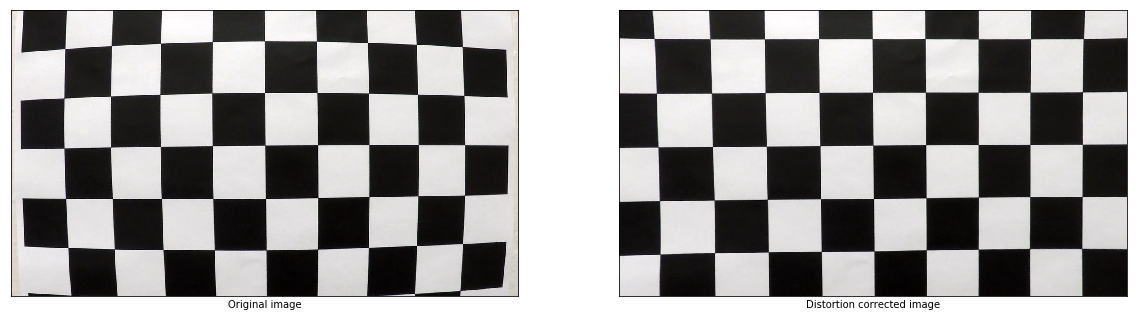

In [8]:
image = mpimage.imread('camera_cal/calibration1.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Distortion corrected image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

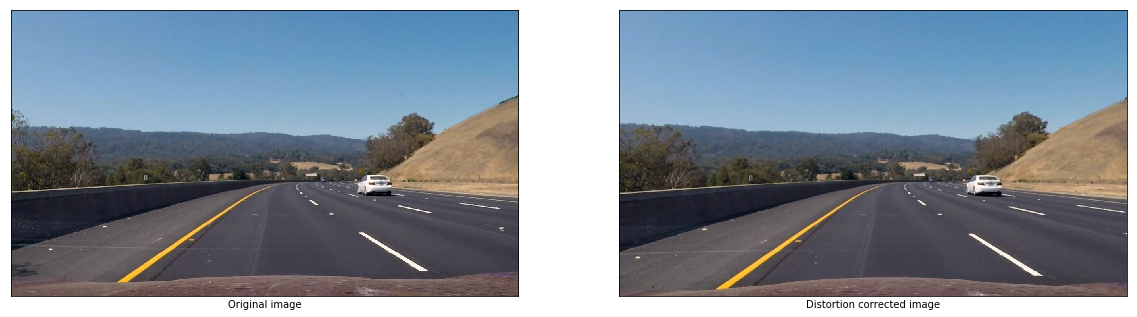

In [9]:
image = mpimage.imread('test_images/test3.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Distortion corrected image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [10]:
# use HLS for color transform

def hls_transform(img, thresh = [90, 255]):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def hsv_transform(img, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    yellow_lane = cv2.inRange(hsv,yellow_hsv_low,yellow_hsv_high)
    white_lane = cv2.inRange(hsv,white_hsv_low,white_hsv_high)
    binary = cv2.bitwise_or(yellow_lane,white_lane)
    
    return binary

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    
    dir_angle = np.arctan2(abs_sobely, abs_sobelx)
    #print (dir_angle)
    
    binary =  np.zeros_like(dir_angle)
    binary[(dir_angle >= thresh[0]) & (dir_angle <= thresh[1])] = 1

    return binary


def abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(90, 225)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary = np.zeros_like(scaled_sobel)
    
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary

    

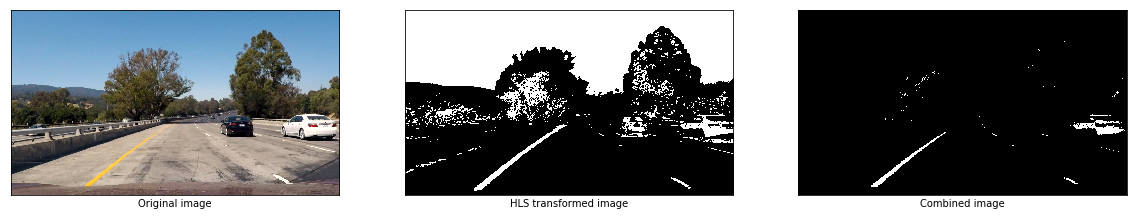

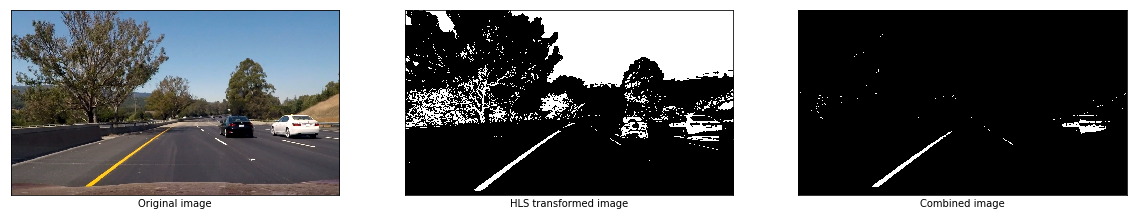

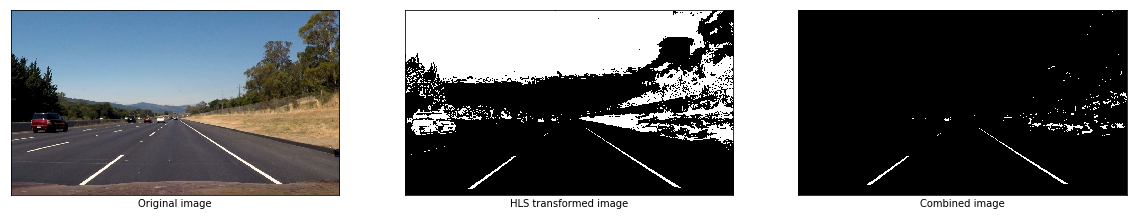

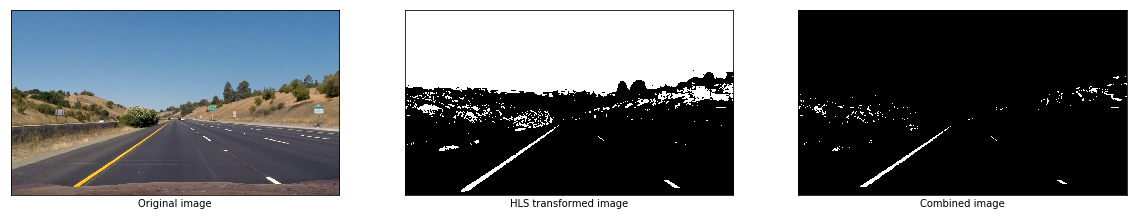

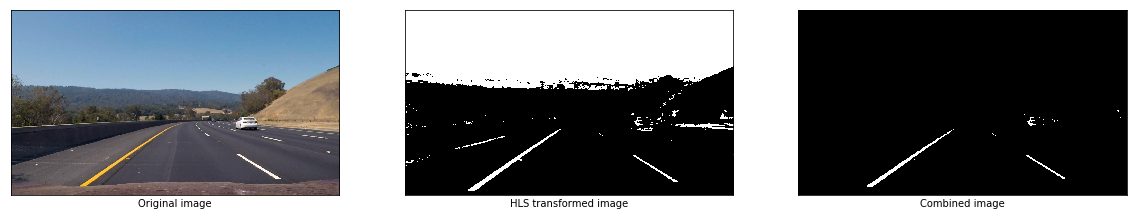

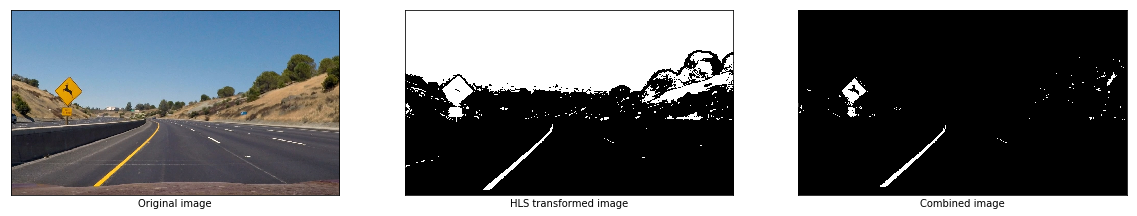

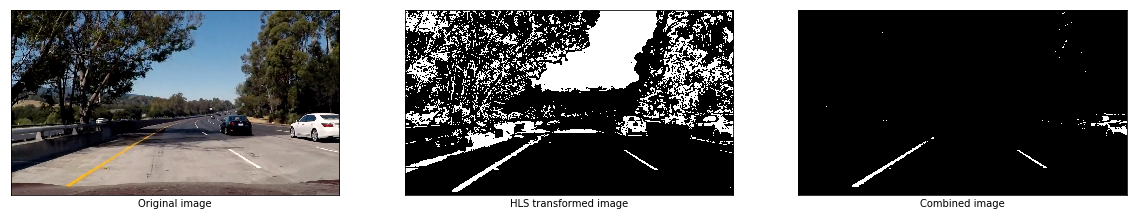

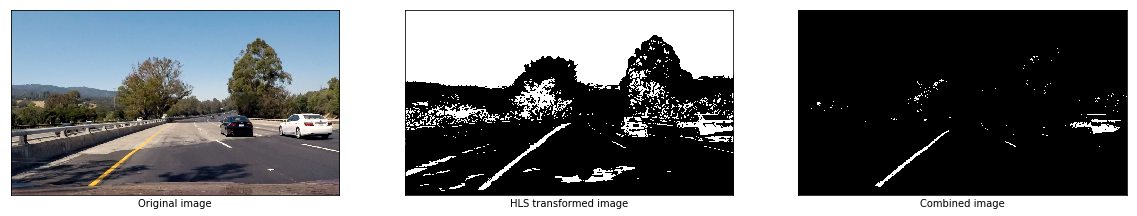

In [11]:
for img in (os.listdir("test_images/")):
    image = mpimage.imread('test_images/' + img)
    # distortion correction
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #apply HLS transform
    binary_S = hls_transform(undist)
    
    binary_dir = dir_threshold(image)
    
    binary_x = abs_sobel_thresh(image)
    binary_y = abs_sobel_thresh(image, 'y')
    
    
    yellow_hsv_low  = np.array([ 18, 80, 100])
    yellow_hsv_high = np.array([ 80, 255, 255])

    white_hsv_low  = np.array([  4,   0,   207])
    white_hsv_high = np.array([ 255,  32, 255])
    binary_hsv = hsv_transform(image, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high)
    
    #print (binary_hsv)
    
    combined = np.zeros_like(binary_dir)
    combined[((binary_S == 1) & (binary_hsv == 255)) ] = 1
    

    plt.figure(figsize=(20,10))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.xlabel('Original image')
    plt.xticks([], [])
    plt.yticks([], [])

    plt.subplot(1, 3, 2)
    plt.imshow(binary_S, cmap='gray')
    plt.xlabel('HLS transformed image')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.subplot(1, 3, 3)
    plt.imshow(combined, cmap='gray')
    plt.xlabel('Combined image')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

In [14]:
# perspective transform
def warp(img, src, des):
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, des)
    
    Minv = cv2.getPerspectiveTransform(des, src)
    
    return M, Minv


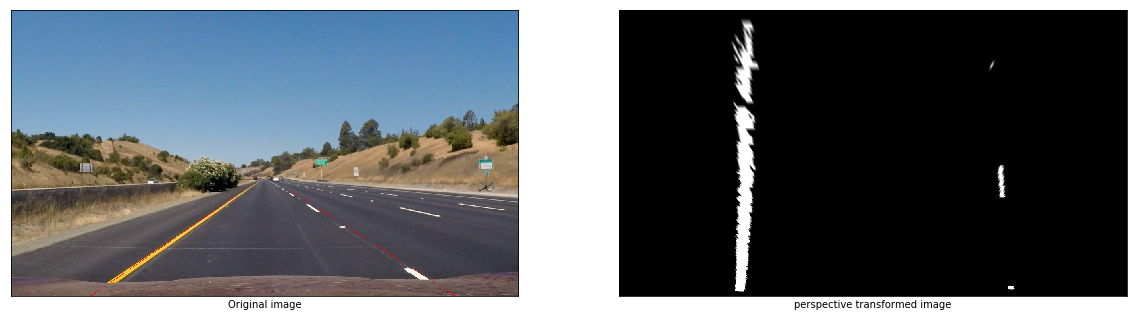

In [26]:
src = np.float32(
    [(200, 720),  # bot left
     (585, 455),  # top left  
     (705, 455),  # top right
     (1120, 720)  # bot right
    ])

des = np.float32(
    [(300, 720), # bot left
    (300, 0), # top left
    (1000, 0), # top right
    (1000, 720), # bot right
    ])

image = mpimage.imread('test_images/' + "straight_lines1.jpg")
img_size = (image.shape[1], image.shape[0])
# distortion correction
undist = cv2.undistort(image, mtx, dist, None, mtx)
#apply HLS transform
binary_S = hls_transform(undist)

binary_dir = dir_threshold(image)

binary_x = abs_sobel_thresh(image)
binary_y = abs_sobel_thresh(image, 'y')


yellow_hsv_low  = np.array([ 18, 80, 100])
yellow_hsv_high = np.array([ 80, 255, 255])

white_hsv_low  = np.array([  4,   0,   207])
white_hsv_high = np.array([ 255,  32, 255])
binary_hsv = hsv_transform(image, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high)

combined = np.zeros_like(binary_dir)
combined[((binary_S == 1) & (binary_hsv == 255)) ] = 1

M, Minv = warp(combined, src, des)

warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

pts = np.array([[200, 720],
                [585, 455],
                [705, 455],
                [1120, 720]], np.int32)
pts = pts.reshape((-1,1,2))

cv2.polylines(image,[pts],True,(255,0,0))

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(warped, cmap='gray')
plt.xlabel('perspective transformed image')
plt.xticks([], [])
plt.yticks([], [])

plt.show()

In [24]:
pts = pts.reshape((-1,1,2))

In [25]:
pts

array([[[ 200,  720]],

       [[ 585,  455]],

       [[ 705,  455]],

       [[1120,  720]]], dtype=int32)